# Pneumonia X-ray Image Classification

<img src="https://media.giphy.com/media/2ldzV2JXHN7G9Nl5iB/giphy.gif">

### Overview

This project analyses over 5,800 chest x-ray images taken of patients both with and without pneumoina and develops a binary classifcation model to predict pneumonia status. The JPEG images were selected from groups of pediatric parients ages one to five years old from Guangzhou Women and Children's Medical Center, Guangzhou China. The World Health Organization(WHO) is requesting a model to help accurately predict pneumonia in young patients.

### Business Problem

Pneumonia is the single largest infectious cause of death in children worldwide and results in 22% of all deaths in children aged 1 to 5. Early identification and intervention is key in preventing young deaths. WHO will use the model to help identify the early stages of pneumonia in children. When building the model, careful consideration was taken to identify and remedy false negatives-pneumonia cases that are incorrectly labeled as normal.

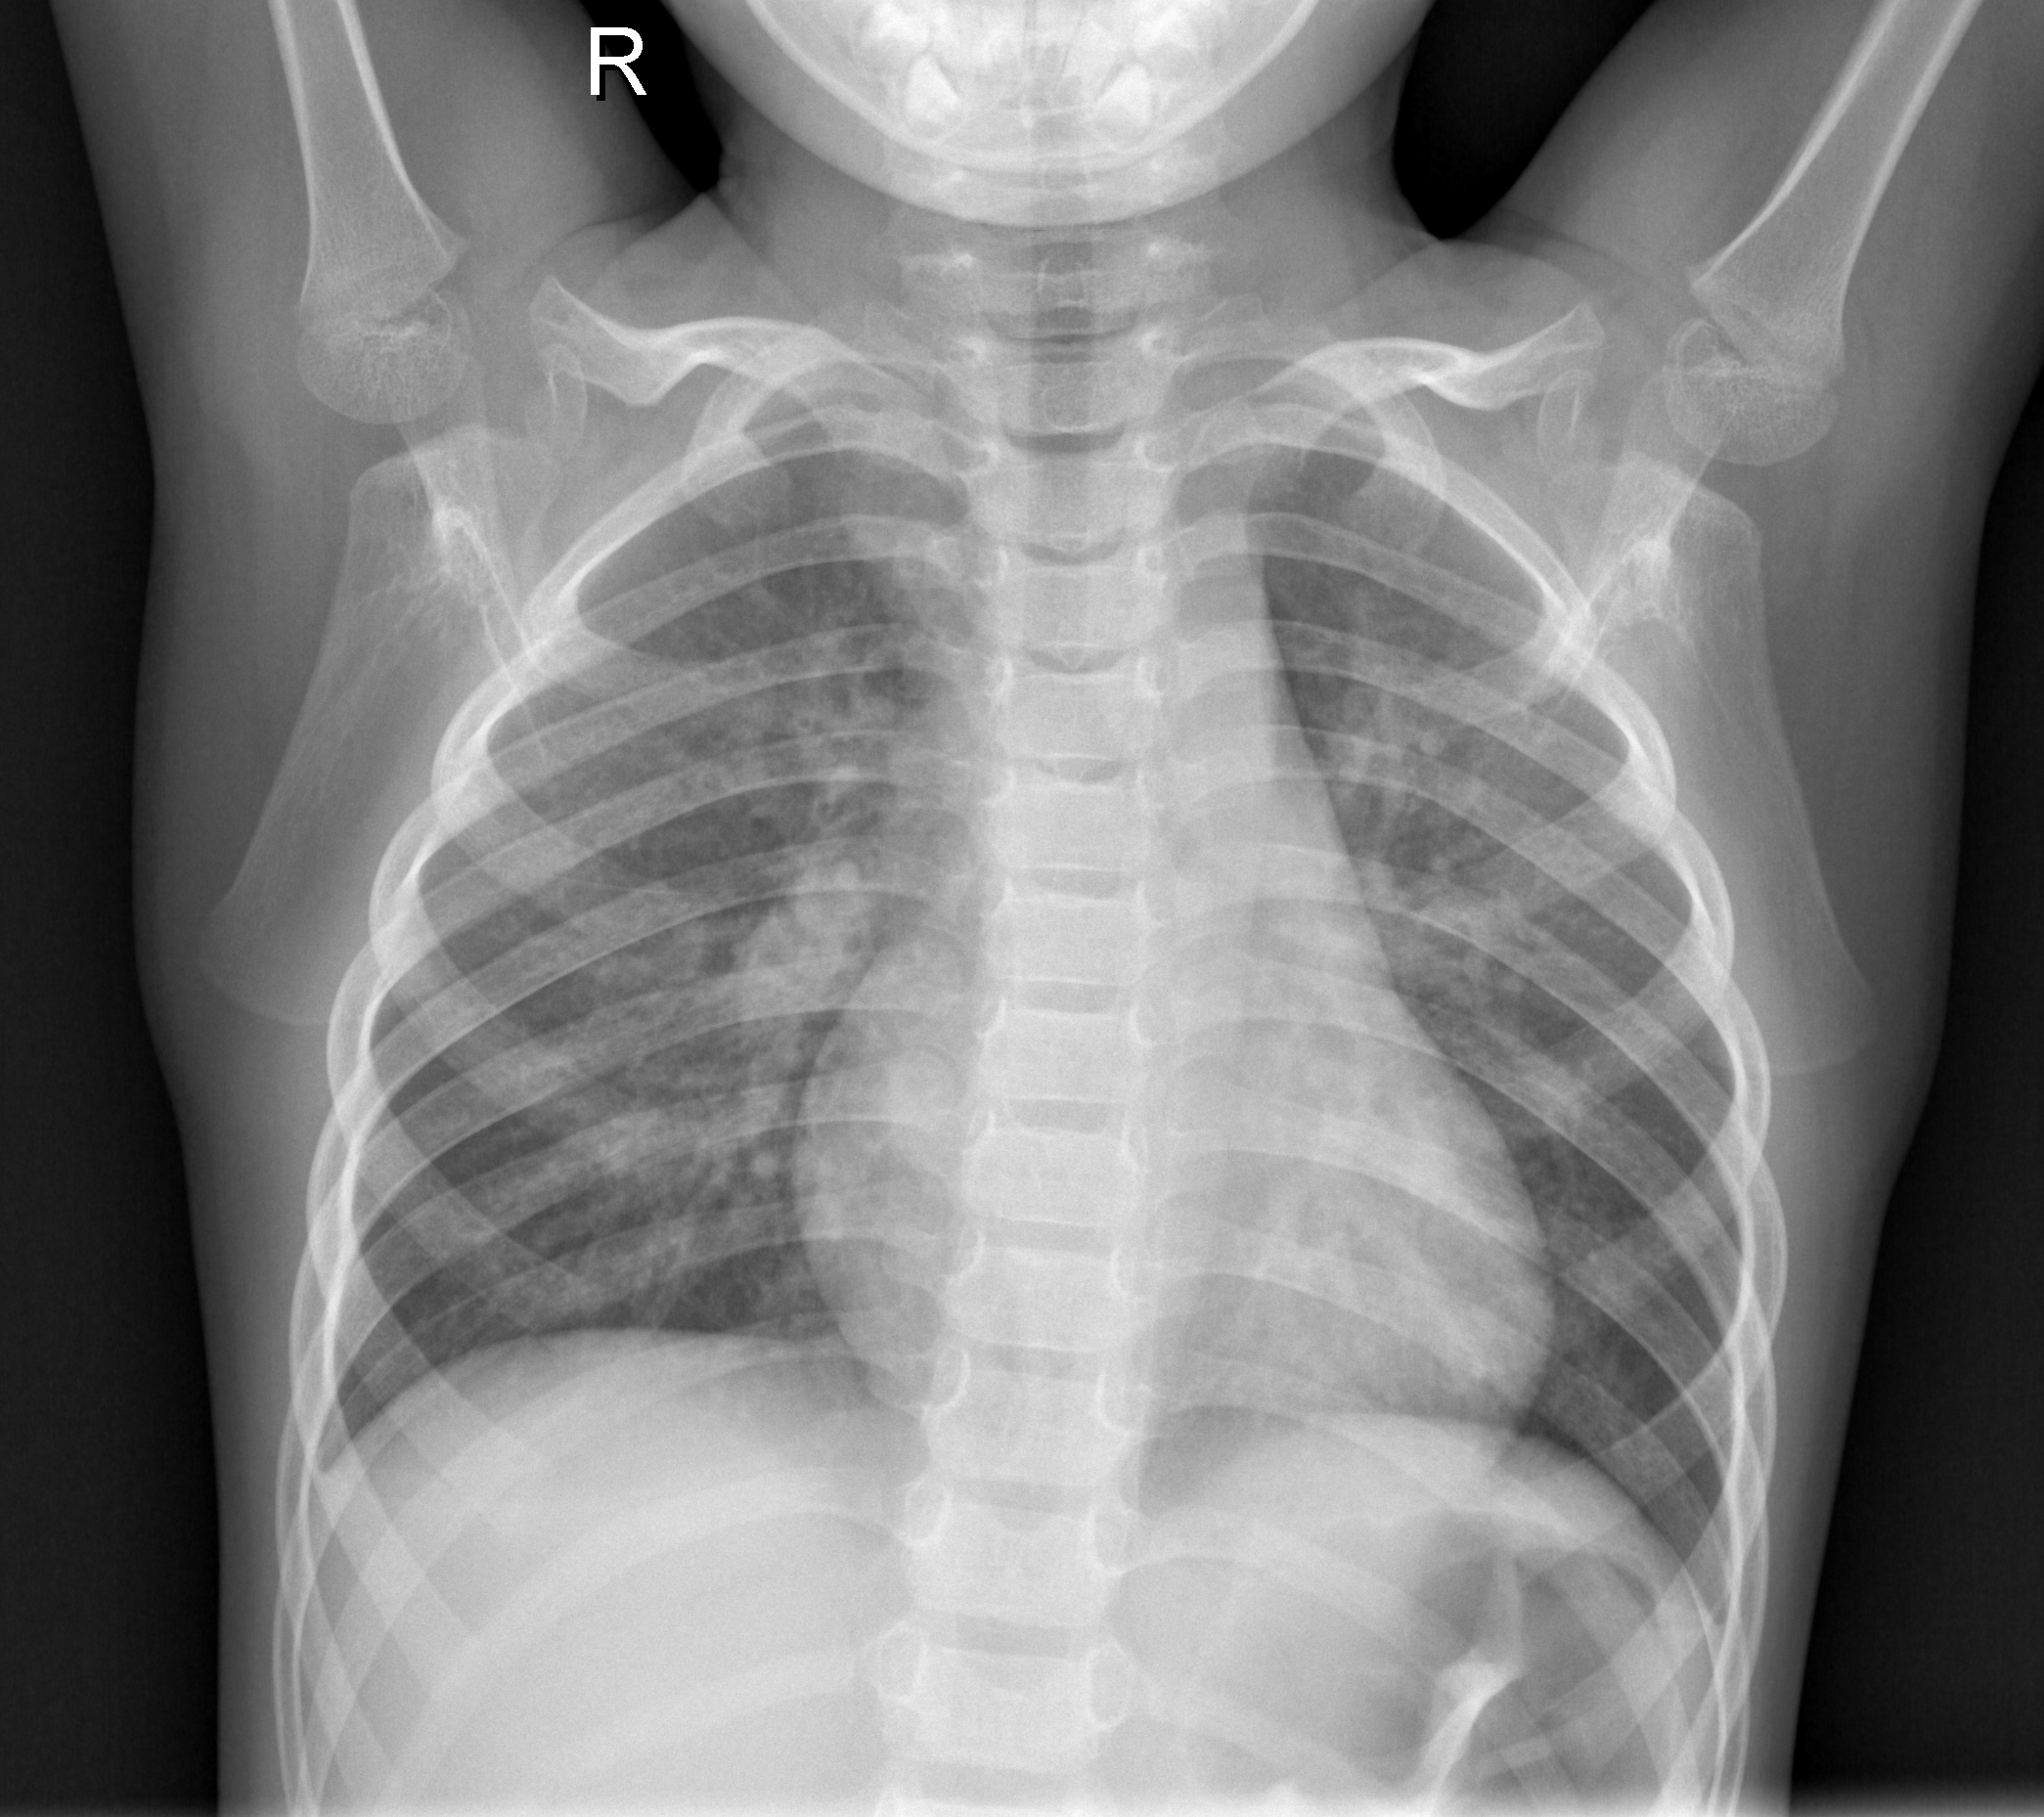

In [243]:
from IPython.display import Image
Image(filename='data/chest_xray/train/NORMAL/IM-0115-0001.jpeg', width=400)


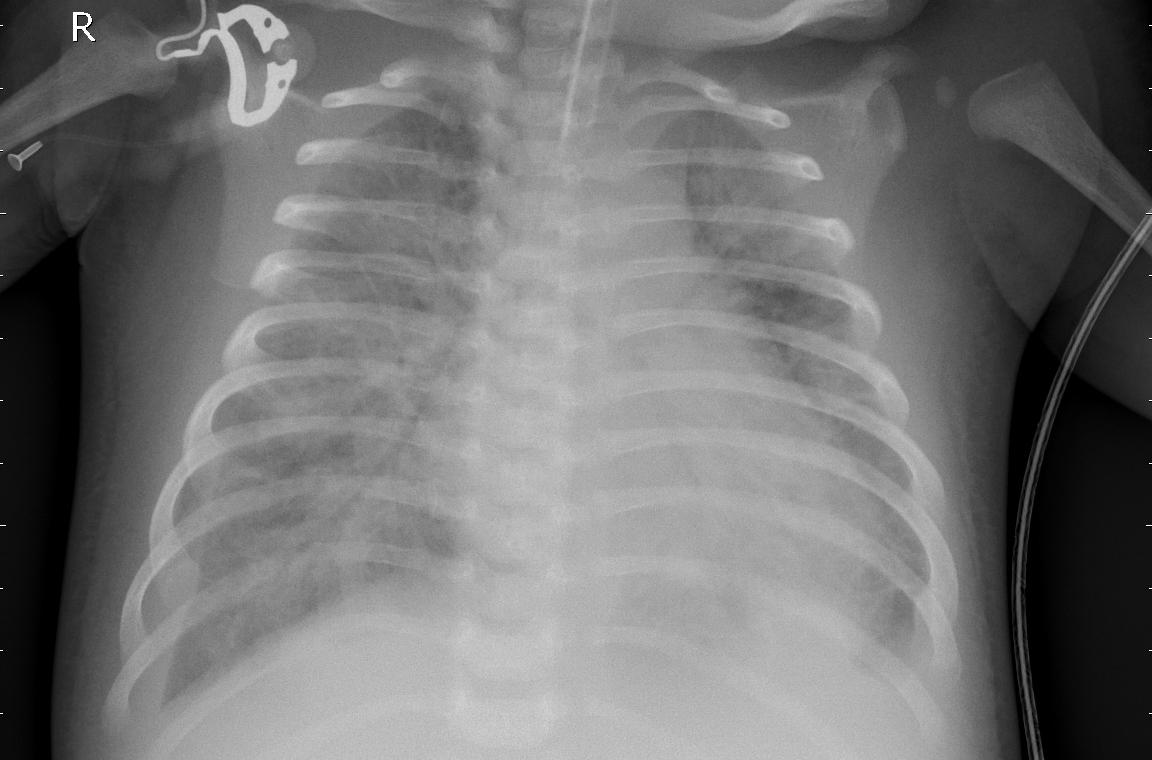

In [242]:
Image(filename='data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg', width=400)

In [265]:
#Importing the relevant libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, LSTM
from keras.datasets import mnist
from keras import regularizers, initializers, optimizers
import os
import datetime
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path
import imagesize

import gc
from timeit import default_timer as timer
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict

In [252]:
#Bringing in the data

train_folder = 'data/chest_xray/train/'
holdout_folder = 'data/chest_xray/val/'
test_folder = 'data/chest_xray/test/'

### Data Understanding

Our images were sourced from Chest X-rays provided by [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2). Our dataset uses over 5800 images of pediatric patients ages one to five from Guangzhou Women and Children's Medical Center. The images were taken as part of the patients routine care. The images were analysed by two expert physicians before being clearned for use in training the AI system and  third expert validated the analysis. 



When first evaluating our data, we see that the validation set only holds 16 images. This is a very small percentage of the number of images avalailable and it does not provide much use as a validation set. To address this, we will create a separate validation set later by splitting our test set into a test and validation set. 


In [251]:
#Function to take counts of normal and pneumonia images in each folder and return them as bar graphs

def pic_count(folder, folder_name):
    dict = {'Normal' :len(os.listdir(folder + '/NORMAL')), 'Pneumonia':len(os.listdir(folder+ '/PNEUMONIA'))}
    fig = px.bar(dict.keys(), dict.values(), title=folder_name, color=list(dict.keys()), orientation='h', color_discrete_sequence=px.colors.sequential.Darkmint, width=800,height=500)
    fig.show()
    
pic_count(holdout_folder, 'Holdout Images')
pic_count(train_folder, 'Training Images')
pic_count(test_folder, 'Test Images')



From the graphs, we can see our images count is very imbalanced. To address this, it would be ideal to increase the number of samples in the 'Normal' class by transforming the images. This will be a technique we will dive into in future iterations of the model.  

We now move to analyzing the average amount of pixels in our images to get an idea of the ideal image size when reshaping and scaling.  

In [270]:
root = 'data/chest_xray/train/NORMAL/'
root1= 'data/chest_xray/train/PNEUMONIA/'

In [271]:
imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root+f)
# Convert it to Dataframe and compute aspect ratio
img_meta_df = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df[["Width", "Height"]] = pd.DataFrame(img_meta_df["Size"].tolist(), index=img_meta_df.index)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)
print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()

Total Nr of Images in the dataset: 1341


,FileName,Size,Width,Height,Aspect Ratio
0,IM-0115-0001.jpeg,"(2090, 1858)",2090,1858,1.12
1,IM-0117-0001.jpeg,"(1422, 1152)",1422,1152,1.23
2,IM-0119-0001.jpeg,"(1810, 1434)",1810,1434,1.26
3,IM-0122-0001.jpeg,"(1618, 1279)",1618,1279,1.27
4,IM-0125-0001.jpeg,"(1600, 1125)",1600,1125,1.42


In [273]:
imgs = [img.name for img in Path(root1).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for f in imgs: img_meta[str(f)] = imagesize.get(root1+f)
# Convert it to Dataframe and compute aspect ratio
img_meta_df1 = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
img_meta_df1[["Width", "Height"]] = pd.DataFrame(img_meta_df1["Size"].tolist(), index=img_meta_df1.index)
img_meta_df1["Aspect Ratio"] = round(img_meta_df1["Width"] / img_meta_df1["Height"], 2)
print(f'Total Nr of Images in the dataset: {len(img_meta_df1)}')
img_meta_df1.head()

Total Nr of Images in the dataset: 3875


,FileName,Size,Width,Height,Aspect Ratio
0,person1000_bacteria_2931.jpeg,"(1152, 760)",1152,760,1.52
1,person1000_virus_1681.jpeg,"(1072, 768)",1072,768,1.40
2,person1001_bacteria_2932.jpeg,"(1244, 863)",1244,863,1.44
3,person1002_bacteria_2933.jpeg,"(1242, 940)",1242,940,1.32
4,person1003_bacteria_2934.jpeg,"(1488, 1280)",1488,1280,1.16


In [274]:
#concat both DataFrames to create visualizations 
total_img_meta_df = pd.concat([img_meta_df, img_meta_df1], axis=0)
total_img_meta_df.shape

(5216, 5)

Looking at the breakdown of our dataframe, we can see the spread of the width and heights of the images in our datasets. We can see that the majority of the images are between 1050 and 1550 in width, and between 700 and 1150 in height. These images are large, and with more computing power we would be able to analyse them at larger sizes. Becuase of our computing limitations, we will have to scale the images down, losing some information as a result. 

In [280]:
total_img_meta_df.describe()

,Width,Height,Aspect Ratio
count,5216.000000,5216.000000,5216.000000
mean,1320.610813,968.074770,1.440240
std,355.298743,378.855691,0.257319
min,384.000000,127.000000,0.840000
25%,1056.000000,688.000000,1.260000
50%,1284.000000,888.000000,1.410000
75%,1552.000000,1187.750000,1.580000
max,2916.000000,2663.000000,3.380000


In [283]:
#Visualizing the sizes of images in the dataset

fig = px.scatter(total_img_meta_df, 
                  x='Width', 
                  y='Height',
                  #size='Width',
                  color_discrete_sequence=px.colors.sequential.dense,
                  template='plotly_dark',
                  opacity=.4,
                  title='Train Image Sizes'
                 )
fig.show()
#About 80% of images are between 800 and 1550 Width
fig2 = px.histogram(total_img_meta_df, 
                    x='Width', 
                    y='Height',  
                    color_discrete_sequence=
                    px.colors.sequential.ice_r, 
                    template='plotly_dark',
                    title='Train Image Width'
                   )
fig2.show()

fig3 = px.histogram(total_img_meta_df, 
                    x='Height', 
                    y='Width',  
                    color_discrete_sequence=
                    px.colors.sequential.ice_r, 
                    template='plotly_dark',
                    title='Train Image Height'
                   )
fig3.show()

### Image Data Pre-processing

We want to start pre-processing our images before putting them through the models. Our pre-processing will ensure all images are the same size and are scaled down to relieve any computational pressure. We can also indicate we are working on a binary classification problem. Our test set has shuffle set to False because we don't want to introduce any extra stochasticity. 

In [286]:
#Rescaling our images and pre-processing them using ImageDataGenerator on train and test sets.
train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_folder, batch_size=5232, target_size=(255,255), class_mode = 'binary')

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_folder, batch_size=624, target_size=(255,255), class_mode = 'binary', shuffle = False)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [285]:
### POSSIBLY REVISIT LATER IF WE HAVE TIME

'''data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=False)'''

In [64]:
#Separating our train and test folders into images and labels

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

0.0


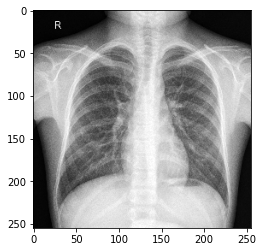

In [65]:
#Photo example
plt.imshow(array_to_img(train_images[0]))
print(train_labels[0])

In [66]:
#Checking the shape of our data to make sure the amount of labels lines up with the images
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(5216, 255, 255, 3)
(5216,)
(624, 255, 255, 3)
(624,)


In [155]:
#Casting our images as float 32s
X_train = train_images.astype('float32')
X_test = test_images.astype('float32')

In [156]:
#Verifying the shape of our data
X_train.shape

(5216, 255, 255, 3)

We will create a separate validation set that will be a subset of our test set. This will be data reserved for testing on our final model. We do this prevent data leakage from our training an testing datasets.

In [157]:
#Performing train test split

X_final_test, X_val, y_final_test, y_val = train_test_split(X_test, test_labels, random_state=42, train_size=.2)

### First Simple Model

Now that we have pre-processed and separated our training, test, and validations sets, we can start modeling. 

For our first model, we wanted to start as simply as possible to evaluate performance. 

In [187]:
model = Sequential(
    [
        Input((255,255,3)),
        Flatten(), # need to flatten our images to be one long array
        Dense(64,activation="relu"),
        Dense(1, activation="sigmoid"),  
        
    ])

model.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_38 (Flatten)         (None, 195075)            0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                12484864  
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 65        
Total params: 12,484,929
Trainable params: 12,484,929
Non-trainable params: 0
_________________________________________________________________


In [188]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [189]:
batch_size = int(X_train.shape[0]/20)

In [190]:
print(train_images.shape)
print(train_labels.shape)

(5216, 255, 255, 3)
(5216,)


In [191]:
history = model.fit(train_images, 
                    train_labels, 
                    batch_size=batch_size,
                    epochs=5, 
                    validation_data=(X_val, y_val))

Epoch 1/5
21/21 [==============================] - 4s 172ms/step - loss: 17.6267 - accuracy: 0.6093 - val_loss: 0.6101 - val_accuracy: 0.6260
Epoch 2/5
21/21 [==============================] - 3s 154ms/step - loss: 0.6855 - accuracy: 0.7429 - val_loss: 0.6919 - val_accuracy: 0.6260
Epoch 3/5
21/21 [==============================] - 3s 143ms/step - loss: 0.6892 - accuracy: 0.7429 - val_loss: 0.6901 - val_accuracy: 0.6260
Epoch 4/5
21/21 [==============================] - 3s 137ms/step - loss: 0.6855 - accuracy: 0.7429 - val_loss: 0.6882 - val_accuracy: 0.6260
Epoch 5/5
21/21 [==============================] - 3s 125ms/step - loss: 0.6816 - accuracy: 0.7429 - val_loss: 0.6863 - val_accuracy: 0.6260


In [192]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

Test loss: 0.6862640380859375
Test accuracy: 0.6259999871253967


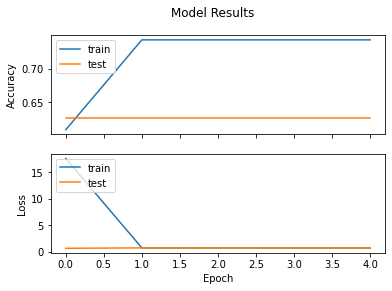

In [193]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

visualize_training_results(history)


In [202]:
model2 = Sequential()
model2.add(Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(1, activation='sigmoid'))

# compiling models
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)

model2.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 255, 255, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 516128)            0         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               66064512  
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 129       
Total params: 66,065,537
Trainable params: 66,065,537
Non-trainable params: 0
_________________________________________________________________


In [203]:

# training
start = timer()

history2 = model2.fit(train_images,
                    train_labels,
                    epochs=20, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/20
163/163 [==============================] - 140s 857ms/step - loss: 0.5304 - accuracy: 0.8138 - recall: 0.9115 - precision: 0.8490 - val_loss: 0.8455 - val_accuracy: 0.6440 - val_recall: 1.0000 - val_precision: 0.6375
Epoch 2/20
163/163 [==============================] - 141s 862ms/step - loss: 0.2104 - accuracy: 0.9160 - recall: 0.9538 - precision: 0.9345 - val_loss: 0.6482 - val_accuracy: 0.7120 - val_recall: 0.9968 - val_precision: 0.6857
Epoch 3/20
163/163 [==============================] - 139s 850ms/step - loss: 0.1647 - accuracy: 0.9388 - recall: 0.9649 - precision: 0.9533 - val_loss: 0.4750 - val_accuracy: 0.8100 - val_recall: 0.9968 - val_precision: 0.7685
Epoch 4/20
163/163 [==============================] - 140s 857ms/step - loss: 0.1385 - accuracy: 0.9469 - recall: 0.9670 - precision: 0.9618 - val_loss: 0.8940 - val_accuracy: 0.6980 - val_recall: 0.9968 - val_precision: 0.6753
Epoch 5/20
163/163 [==============================] - 140s 858ms/step - loss: 0.1170 - a

16/16 - 2s - loss: 0.3522 - accuracy: 0.8720 - recall: 0.9712 - precision: 0.8468
Test loss: 0.3521612286567688
Test accuracy: 0.871999979019165
Test recall: 0.9712460041046143
Test precision: 0.8467966318130493


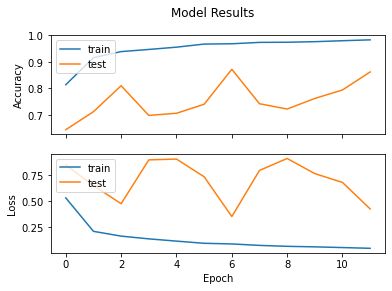

In [288]:
score = model2.evaluate(X_val, y_val, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("Test recall:", score[2])
print("Test precision:", score[3])

visualize_training_results(history2)

In [233]:
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch
    
    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    recall = np.array(hist_['recall'])
    precision = np.array(hist_['precision'])
    val_recall = np.array(hist_['val_recall'])
    val_precision = np.array(hist_['val_precision'])
    plt.figure()
    
    plt.plot(epochs, 
             2*((recall * precision)/(recall + precision)), 
             label='Training f1')
    plt.plot(epochs, 
             2*((val_recall * val_precision)/(val_recall + val_precision)), 
             label='Validation f1')
    plt.title('Training and validation F1-Score')
    plt.legend()
    plt.figure()
    
    
    plt.plot(epochs, recall, label = "Training Recall")
    plt.plot(epochs, val_recall, label = "Validation Recall")
    plt.title("Training and Validation Recall Scores")
    plt.legend()
    plt.figure()
    
    plt.show()

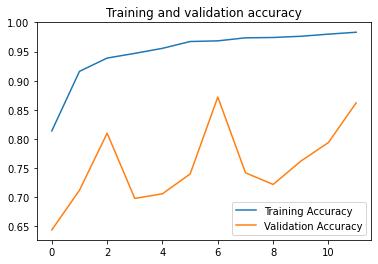

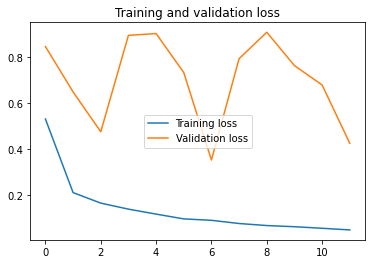

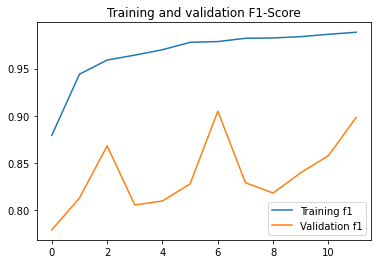

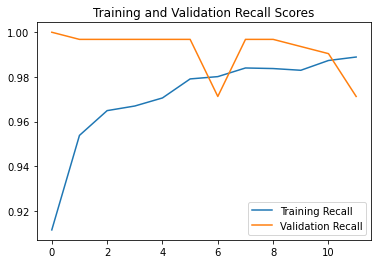

<Figure size 432x288 with 0 Axes>

In [289]:
plot_performance(history2)

In [232]:
model3 = Sequential(
    [
        
        Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (255,255,3)),
        Flatten(), # need to flatten our images to be one long array
        Dense(64,activation="relu"),
        Dropout(.2),
        Dense(1, activation="sigmoid"), 
        
    ])


model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy', 'Recall', 'Precision'])

# early stopping
cp = EarlyStopping(patience = 5, restore_best_weights=True)


model3.summary()



Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 255, 255, 32)      896       
_________________________________________________________________
flatten_51 (Flatten)         (None, 2080800)           0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                133171264 
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 65        
Total params: 133,172,225
Trainable params: 133,172,225
Non-trainable params: 0
_________________________________________________________________


In [218]:
start = timer()

history3 = model3.fit(train_images,
                    train_labels,
                    epochs=5, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/5
163/163 [==============================] - 210s 1s/step - loss: 2.1272 - accuracy: 0.7429 - recall: 0.8480 - precision: 0.8138 - val_loss: 0.4849 - val_accuracy: 0.7480 - val_recall: 0.9872 - val_precision: 0.7169
Epoch 2/5
163/163 [==============================] - 203s 1s/step - loss: 0.3819 - accuracy: 0.8541 - recall: 0.9066 - precision: 0.8980 - val_loss: 0.4459 - val_accuracy: 0.7800 - val_recall: 0.9904 - val_precision: 0.7434
Epoch 3/5
163/163 [==============================] - 204s 1s/step - loss: 0.2729 - accuracy: 0.9026 - recall: 0.9370 - precision: 0.9322 - val_loss: 0.4674 - val_accuracy: 0.7840 - val_recall: 0.9808 - val_precision: 0.7506
Epoch 4/5
163/163 [==============================] - 208s 1s/step - loss: 0.2169 - accuracy: 0.9153 - recall: 0.9432 - precision: 0.9427 - val_loss: 0.4610 - val_accuracy: 0.7980 - val_recall: 0.9776 - val_precision: 0.7650
Epoch 5/5
163/163 [==============================] - 210s 1s/step - loss: 0.1890 - accuracy: 0.9268 - re

16/16 [==============================] - 2s 118ms/step - loss: 0.3683 - accuracy: 0.8480 - recall: 0.9712 - precision: 0.8194
Test loss: 0.368346631526947
Test accuracy: 0.8479999899864197


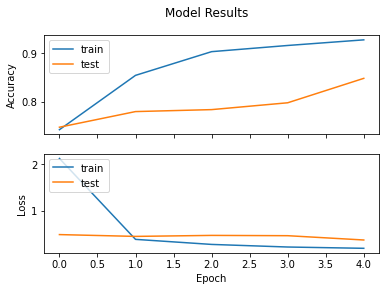

In [220]:
score = model3.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

visualize_training_results(history3)

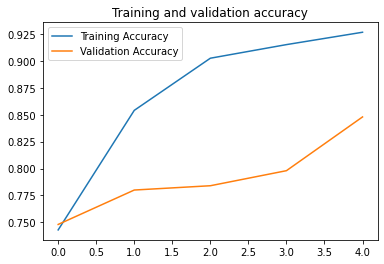

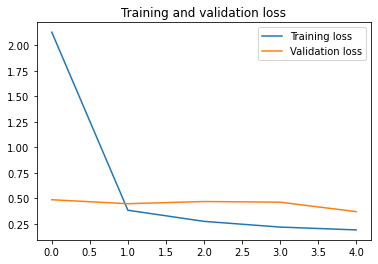

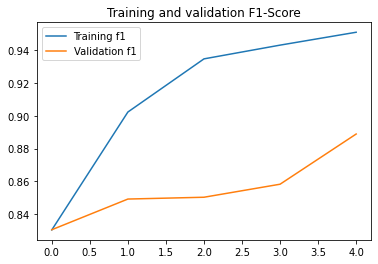

In [221]:
plot_performance(history3)

With this model running for only 5 epochs, we are seeing a nice upward trend in accuracy, and a nice downward trend in loss. This indicate we should try letting our model run for a bit longer. We will bump our epochs up to 50 to see if we can make some improvements. 

In [225]:
start = timer()

history4 = model3.fit(train_images,
                    train_labels,
                    epochs=50, 
                    validation_data =(X_val,y_val),
                    workers = 7, 
                    callbacks = [cp], 
                    verbose = 1
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/50
163/163 [==============================] - 213s 1s/step - loss: 0.8828 - accuracy: 0.7253 - recall: 0.9505 - precision: 0.7480 - val_loss: 0.5599 - val_accuracy: 0.6260 - val_recall: 1.0000 - val_precision: 0.6260
Epoch 2/50
163/163 [==============================] - 211s 1s/step - loss: 0.3598 - accuracy: 0.8499 - recall: 0.9280 - precision: 0.8771 - val_loss: 0.6465 - val_accuracy: 0.6640 - val_recall: 1.0000 - val_precision: 0.6507
Epoch 3/50
163/163 [==============================] - 212s 1s/step - loss: 0.3186 - accuracy: 0.8798 - recall: 0.9249 - precision: 0.9143 - val_loss: 0.5437 - val_accuracy: 0.6880 - val_recall: 0.9968 - val_precision: 0.6681
Epoch 4/50
163/163 [==============================] - 199s 1s/step - loss: 0.2942 - accuracy: 0.9013 - recall: 0.9357 - precision: 0.9317 - val_loss: 0.6498 - val_accuracy: 0.7580 - val_recall: 0.9936 - val_precision: 0.7233
Epoch 5/50
163/163 [==============================] - 208s 1s/step - loss: 0.2769 - accuracy: 0.9091

16/16 [==============================] - 2s 127ms/step - loss: 0.7083 - accuracy: 0.3740 - recall: 0.0000e+00 - precision: 0.0000e+00
Test loss: 0.7083160877227783
Test accuracy: 0.37400001287460327


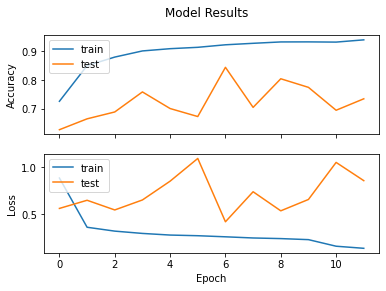

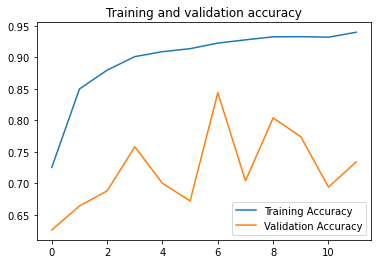

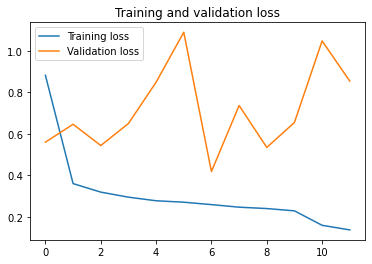

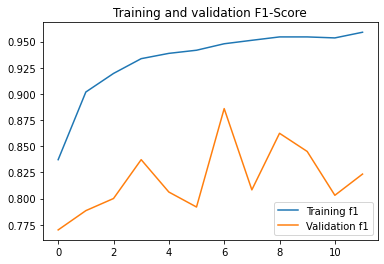

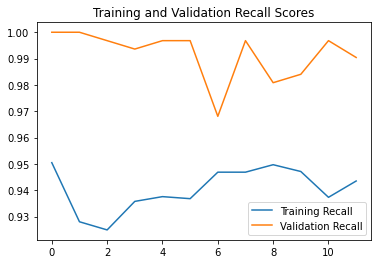

<Figure size 432x288 with 0 Axes>

In [235]:
score = model3.evaluate(X_val, y_val, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

visualize_training_results(history4)


plot_performance(history4)